## Datathon Project : Predict Future Sales by CO2

데이터 불러오기 및 기초 처리

In [1]:
# 데이터 처리, 모델 구축, 시각화를 위한 주요 라이브러리 및 모듈을 불러옵니다.
import gc  # Python의 가비지 컬렉터 관련 모듈로, 메모리 관리를 위해 객체 삭제를 명시적으로 제어할 수 있습니다.
import itertools  # 반복 가능한 객체로부터 조합, 순열 등 다양한 반복자를 생성하는 유틸리티 모듈입니다.
import matplotlib.pyplot as plt  # 정적/애니메이션/인터랙티브 시각화를 지원하는 matplotlib의 핵심 시각화 도구입니다.
import numpy as np  # 다차원 배열과 행렬 연산, 다양한 수학 함수 제공을 위한 수치 계산 라이브러리입니다.
import pandas as pd  # 데이터 프레임과 시리즈 객체를 기반으로 한 데이터 분석용 라이브러리입니다.
import seaborn as sns  # matplotlib을 기반으로 한 고급 통계 시각화 라이브러리입니다.
import os  # 운영체제와 상호작용하기 위한 모듈로, 파일 경로 탐색 등 OS 의존 기능을 지원합니다.
import xgboost  # 머신러닝용 XGBoost 라이브러리 (주로 회귀, 분류, 랭킹에 사용).
import warnings  # 경고 메시지 필터링 및 제어를 위한 모듈입니다.
import lightgbm as lgbm  # LightGBM: 그래디언트 부스팅 기반 머신러닝 프레임워크입니다.
import lightgbm as lgb  # LightGBM을 다른 별칭으로 중복 임포트 (보통은 하나만 임포트해도 충분합니다).
import ctypes  # C 언어 호환 데이터 타입을 사용하거나 외부 DLL/공유 라이브러리 호출 시 사용되는 모듈입니다.
from sklearn.linear_model import LinearRegression  # 선형 회귀 모델을 구현하는 클래스입니다.

warnings.filterwarnings("ignore")  # 경고 메시지를 무시하여 출력 결과가 지저분하지 않도록 설정합니다.

In [3]:
# 쥬피터 노트북용 데이터 불러오기
df_train = pd.read_csv('./sales_train.csv')
df_categories = pd.read_csv("./item_categories.csv")
df_items = pd.read_csv("./items-translated.csv", encoding='cp1252') # 번역 후 파일을 input 폴더에 올려두었습니다. 파일명: items_translated
df_shops = pd.read_csv("./shops_graded.csv", encoding='cp1252') # 매장 등급 추가한 파일을 input 폴더에 올려두었습니다. 파일명: shops_graded
df_test = pd.read_csv("./test.csv")
calendar = pd.read_csv("./calendar.csv")

In [4]:
# 데이터 병합
df_train['date'] = pd.to_datetime(df_train['date'], format='%d.%m.%Y')
calendar['date'] = pd.to_datetime(calendar['date'])

df_train = pd.merge(df_train, df_items, on='item_id', how='inner')
df_train = pd.merge(df_train, df_categories, on='item_category_id', how='inner')
df_train = pd.merge(df_train, df_shops, on='shop_id', how='inner')
df_test = pd.merge(df_test, df_items, on='item_id', how='inner')
df_test = pd.merge(df_test, df_categories, on='item_category_id', how='inner')
df_test = pd.merge(df_test, df_shops, on='shop_id', how='inner')
df_train = pd.merge(df_train, calendar, on='date', how='left')

In [5]:
# category, shop 중분류 추가 (12초 소요)
df_train['city'] = df_train['shop_name'].str.split(' ').str[0]
df_train['sub_category'] = df_train['item_category_name'].str.split(' ').str[0]
# 중분류명 정리 → 13개
df_train['sub_category'] = df_train['sub_category'].replace({'Pure' : 'Carrier', 'Clean' : 'Carrier', 'Elements': 'Batteries', 'Payment' : 'Gift Card', 'Service' : 'Tickets', 'Android' : 'Games', 'Mac' : 'Games', 'Game' : 'Games'})
# city명 정리
df_train['city'] = df_train['city'].replace({'!' : 'Yakutsk', 'Exit' : 'Other', 'N.' : 'NizhnyNovgorod', 'SPb' : 'SanktPetersburg', 'Digital' : 'Online'})
# 원화 추가
df_train['total_amount'] = df_train['item_price'] * df_train['item_cnt_day'] # 판매 금액
df_train['krw_amount'] = df_train['total_amount'] * 18 # 국내 보고용 원화 표시, krw_amount로 표시
df_train = df_train.rename({'total_amount':'rub_amount'}, axis = 1)  # 기존 판매금액은 rub_amount로 표시

In [6]:
# dat 관련 컬럼 추가 # 보고용이므로 예측에는 불필요 시 사용하지 않아도 됩니다. (7초 소요)
# df_train['date'] = pd.to_datetime(df_train['date'], format='%d.%m.%Y') (merge 직전에 완료)
df_train['year'] =  pd.to_datetime(df_train['date']).apply(lambda x : x.year)
df_train['month'] = pd.to_datetime(df_train['date']).apply(lambda x : x.month)
df_train['day'] = pd.to_datetime(df_train['date']).apply(lambda x : x.day)
df_train['year_month'] = df_train['date'].dt.to_period('M')

In [7]:
df_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name_translated,item_category_id,item_category_name,shop_name,...,holiday,weekend,city,sub_category,rub_amount,krw_amount,year,month,day,year_month
0,2013-01-02,0,59,22154,999.00,1.0,SCENE 2012 (BD),37,Cinema - Blu -Ray,"Yaroslavl shopping center ""Altair""",...,1,0,Yaroslavl,Cinema,999.00,17982.0,2013,1,2,2013-01
1,2013-01-03,0,25,2552,899.00,1.0,DEEP PURPLE The House Of Blue Light LP,58,Music - vinyl,"Moscow TRK ""Atrium""",...,1,0,Moscow,Music,899.00,16182.0,2013,1,3,2013-01
2,2013-01-05,0,25,2552,899.00,-1.0,DEEP PURPLE The House Of Blue Light LP,58,Music - vinyl,"Moscow TRK ""Atrium""",...,0,1,Moscow,Music,-899.00,-16182.0,2013,1,5,2013-01
3,2013-01-06,0,25,2554,1709.05,1.0,DEEP PURPLE Who Do You Think We Are LP,58,Music - vinyl,"Moscow TRK ""Atrium""",...,0,1,Moscow,Music,1709.05,30762.9,2013,1,6,2013-01
4,2013-01-15,0,25,2555,1099.00,1.0,DEEP PURPLE 30 Very Best Of 2CD (Ð¤Ð¸?Ð¼.),56,Music - CD of corporate production,"Moscow TRK ""Atrium""",...,0,0,Moscow,Music,1099.00,19782.0,2013,1,15,2013-01


이상치 제거

In [8]:
df_train[df_train.duplicated() == True]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name_translated,item_category_id,item_category_name,shop_name,...,holiday,weekend,city,sub_category,rub_amount,krw_amount,year,month,day,year_month
76962,2013-01-05,0,54,20130,149.0,1.0,SCIENTIFIC CHARODEA (region),40,Cinema - DVD,"Khimki shopping center ""mega""",...,0,1,Khimki,Cinema,149.0,2682.0,2013,1,5,2013-01


In [9]:
# 중복 제거 # 6개 건
df_train.drop_duplicates(inplace=True)

In [10]:
df_train.columns

Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day', 'item_name_translated', 'item_category_id',
       'item_category_name', 'shop_name', 'shop_grade', 'holiday', 'weekend',
       'city', 'sub_category', 'rub_amount', 'krw_amount', 'year', 'month',
       'day', 'year_month'],
      dtype='object')

In [11]:
pd.set_option('display.max_columns', None)
df_train.head(20)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name_translated,item_category_id,item_category_name,shop_name,shop_grade,holiday,weekend,city,sub_category,rub_amount,krw_amount,year,month,day,year_month
0,2013-01-02,0,59,22154,999.00,1.0,SCENE 2012 (BD),37,Cinema - Blu -Ray,"Yaroslavl shopping center ""Altair""",C,1,0,Yaroslavl,Cinema,999.00,17982.0,2013,1,2,2013-01
1,2013-01-03,0,25,2552,899.00,1.0,DEEP PURPLE The House Of Blue Light LP,58,Music - vinyl,"Moscow TRK ""Atrium""",A,1,0,Moscow,Music,899.00,16182.0,2013,1,3,2013-01
2,2013-01-05,0,25,2552,899.00,-1.0,DEEP PURPLE The House Of Blue Light LP,58,Music - vinyl,"Moscow TRK ""Atrium""",A,0,1,Moscow,Music,-899.00,-16182.0,2013,1,5,2013-01
3,2013-01-06,0,25,2554,1709.05,1.0,DEEP PURPLE Who Do You Think We Are LP,58,Music - vinyl,"Moscow TRK ""Atrium""",A,0,1,Moscow,Music,1709.05,30762.9,2013,1,6,2013-01
4,2013-01-15,0,25,2555,1099.00,1.0,DEEP PURPLE 30 Very Best Of 2CD (Ð¤Ð¸?Ð¼.),56,Music - CD of corporate production,"Moscow TRK ""Atrium""",A,0,0,Moscow,Music,1099.00,19782.0,2013,1,15,2013-01
5,2013-01-10,0,25,2564,349.00,1.0,DEEP PURPLE Perihelion: Live In Concert DVD (?...,59,Music - music video,"Moscow TRK ""Atrium""",A,0,0,Moscow,Music,349.00,6282.0,2013,1,10,2013-01
6,2013-01-02,0,25,2565,549.00,1.0,DEEP PURPLE Stormbringer (?Ð¸?Ð¼.),56,Music - CD of corporate production,"Moscow TRK ""Atrium""",A,1,0,Moscow,Music,549.00,9882.0,2013,1,2,2013-01
7,2013-01-04,0,25,2572,239.00,1.0,DEFTONES Koi No Yokan,55,Music - CD of local production,"Moscow TRK ""Atrium""",A,1,0,Moscow,Music,239.00,4302.0,2013,1,4,2013-01
8,2013-01-11,0,25,2572,299.00,1.0,DEFTONES Koi No Yokan,55,Music - CD of local production,"Moscow TRK ""Atrium""",A,0,0,Moscow,Music,299.00,5382.0,2013,1,11,2013-01
9,2013-01-03,0,25,2573,299.00,3.0,DEL REY LANA Born To Die,55,Music - CD of local production,"Moscow TRK ""Atrium""",A,1,0,Moscow,Music,897.00,16146.0,2013,1,3,2013-01


목적: 2015년 10월 매출 분석 및 2015년 11월 매출 예측  
1. 2015년 10월 매출 분석
2. 2015년 11월 운영 전략
3. 2015년 11월 매출 예측

### 2015년 10월 매출 분석
- 2015년 10월 데이터만 필터링
- 연간 대비 상승/하락 (2014년 10월과 2015년 10월 데이터 비교)
- 전월 대비, 전년 동월 대비 (2015년 9월, 2014년 10월 데이터 비교)
- 결과 => 매장별 판매, 카테고리별 총 판매량 / SKU 개수 / 판매 주수(몇 주 동안 팔렸는지)

### 그룹별 점평균 매출 현황

In [12]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 932450 entries, 0 to 932450
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   date                  932450 non-null  datetime64[ns]
 1   date_block_num        932450 non-null  int64         
 2   shop_id               932450 non-null  int64         
 3   item_id               932450 non-null  int64         
 4   item_price            932449 non-null  float64       
 5   item_cnt_day          932449 non-null  float64       
 6   item_name_translated  932450 non-null  object        
 7   item_category_id      932450 non-null  int64         
 8   item_category_name    932450 non-null  object        
 9   shop_name             932450 non-null  object        
 10  shop_grade            932450 non-null  object        
 11  holiday               932450 non-null  int64         
 12  weekend               932450 non-null  int64         
 13  city

In [13]:
import pandas as pd

# 1. 2015년 10월 vs 전월(9월) / 전년(2014년 10월) 매출 비교

# 2015년 10월, 2015년 9월, 2014년 10월의 매출만 필터링
compare_months = ['2015-10', '2015-09', '2014-10']
monthly_sales = df_train[df_train['year_month'].astype(str).isin(compare_months)]

# 월별 매출 총합 계산
monthly_summary = monthly_sales.groupby('year_month')[['rub_amount', 'krw_amount']].sum().sort_index()
pd.set_option('display.float_format', '{:,.0f}'.format)

monthly_summary

,rub_amount,krw_amount
year_month,,


#### 연간 대비 상승/하락 (2014년 10월과 2015년 10월 데이터 비교)

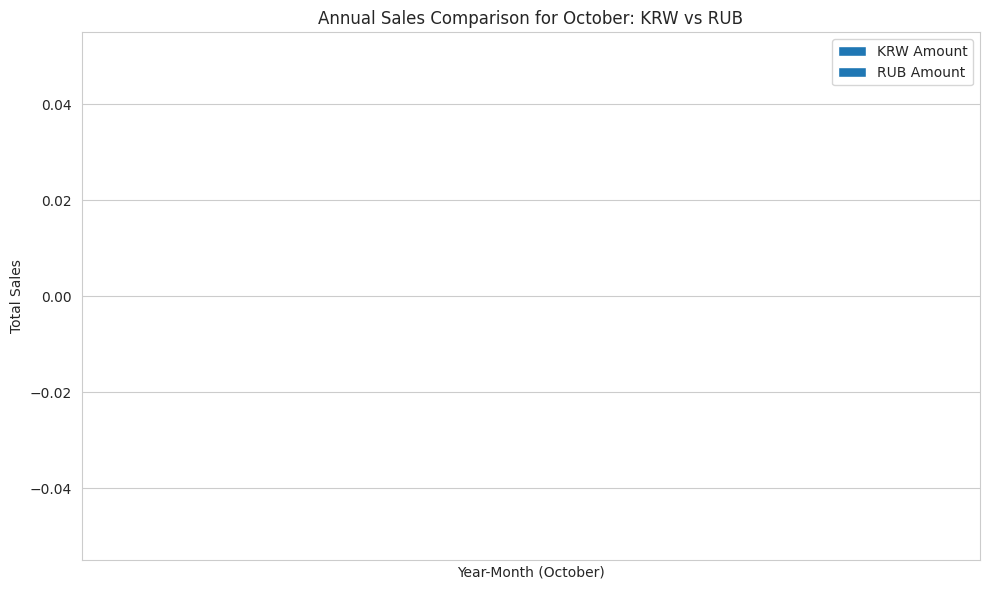

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# 비교할 연도 10월 데이터 필터링
compare_years = ['2013-10', '2014-10', '2015-10']
annual_sales = df_train[df_train['year_month'].astype(str).isin(compare_years)]

# 연도별 매출 합계 계산
annual_summary = annual_sales.groupby('year_month')[['rub_amount', 'krw_amount']].sum().sort_index()

# 스타일 설정
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))

# 데이터 재정렬 및 인덱스 생성
annual_summary_reset = annual_summary.reset_index()
bar_width = 0.35
index = range(len(annual_summary_reset))

# 한화 매출 막대
plt.bar(index, annual_summary_reset['krw_amount'], bar_width, label='KRW Amount', color='skyblue')

# 루블 매출 막대
plt.bar([i + bar_width for i in index], annual_summary_reset['rub_amount'], bar_width, label='RUB Amount', color='orange')

# x축 라벨 설정 (2013-10, 2014-10, 2015-10)
plt.xticks([i + bar_width / 2 for i in index], annual_summary_reset['year_month'])
plt.xlabel('Year-Month (October)')
plt.ylabel('Total Sales')
plt.title('Annual Sales Comparison for October: KRW vs RUB')
plt.legend()

plt.tight_layout()
plt.show()


#### 전월 대비, 전년 동월 대비 (2015년 9월, 2014년 10월 데이터 비교)

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

# 각 비교별 % 변화율 계산 (루블, 한화 합계 기준)
# rub_amount와 krw_amount 합친 총 매출 기준으로 할 수도 있지만, 여기서는 krw_amount 기준으로 예시 작성

month_rate = (monthly_summary.loc['2015-10', 'krw_amount'] / monthly_summary.loc['2015-09', 'krw_amount'] - 1) * 100
year_month_rate = (monthly_summary.loc['2015-10', 'krw_amount'] / monthly_summary.loc['2014-10', 'krw_amount'] - 1) * 100

# 데이터 프레임 생성
rates = pd.Series([ month_rate, year_month_rate],
                  index=['Monthly Sales Change Rate\n(2015-10 vs 2015-09)', 'Year-Month Sales Change Rate\n(2015-10 vs 2014-10)'])

plt.figure(figsize=(7,5))
bars = plt.bar(rates.index, rates.values, color='skyblue')

plt.ylabel('Change Rate (%)')
plt.title('Sales Change Rate') # Rub이나 KRW이나 비율은 같음
plt.ylim(min(rates.values.min() - 5, -20), max(rates.values.max() + 5, 20))

# 막대 위에 값 표시
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f'{height:.1f}%',
             ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()


KeyError: '2015-10'

| 구분                              | 비교 대상                   | 매출 변화율 (%) | 의미                                           |
|---------------------------------|----------------------------|----------------|------------------------------------------------|
| 전월 대비 (Monthly Sales Change Rate)      | 2015년 10월 vs 2015년 9월    | -9.2%          | 전월대비: 2015년 9월 대비 2015년 10월 매출이 약 9.2% 감소함 |
| 전년 동월 대비 (Year-Month Sales Change Rate) | 2015년 10월 vs 2014년 10월     | -25.1%         | 전년 동월대비: 2015년 10월 매출이 2014년 10월 대비 약 25.1% 감소함    |


In [ ]:
df_train.columns

#### 결과 => 매장별 판매, 카테고리별 총 판매량

In [ ]:
df_201510 = df_train[df_train['year_month'] == '2015-10']

store_sales = df_201510.groupby('shop_id')['item_cnt_day'].sum().reset_index().rename(columns={'item_cnt_day': 'total_cnt'})
store_sales = store_sales.sort_values(by='total_cnt', ascending=False)

category_sales = df_201510.groupby('sub_category')['item_cnt_day'].sum().reset_index().rename(columns={'item_cnt_day': 'total_cnt'})
category_sales = store_sales.sort_values(by='total_cnt', ascending=False)

print("매장별 총 판매량:")
print(store_sales)

print("\n카테고리별 총 판매량:")
print(category_sales)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_style('whitegrid')

grades = np.sort(df_train['shop_grade'].unique())  # 오름차순 정렬 (A, B, C, D...)

for g in grades:
    # 해당 grade의 데이터 필터링
    data = df_train[df_train['shop_grade'] == g]

    # 매장별 총 판매량 계산
    store_sales = data.groupby(['shop_id', 'shop_name'])['item_cnt_day'].sum().reset_index(name='total_cnt')

    # 판매량 기준 내림차순 정렬
    store_sales = store_sales.sort_values(by='total_cnt', ascending=False)

    plt.figure(figsize=(12,6))
    sns.barplot(data=store_sales, x='shop_name', y='total_cnt', palette='Blues_d')
    plt.title(f'Grade {g} by shop Total Sales Count')
    plt.xlabel('Shop Name')
    plt.ylabel('Total Sales Count')
    plt.xticks(rotation=70)
    plt.tight_layout()
    plt.show()


# 컨텐츠 샘플

### 그룹별 점평균 매출 현황

In [ ]:
# 1. 일별 매출 컬럼 생성
df_train['daily_sales'] = df_train['item_price'] * 18 * df_train['item_cnt_day']

# 2. 상점별 전체 매출 계산
shop_total_sales = (
    df_train
    .groupby('shop_grade')['daily_sales']
    .sum()
    .reset_index(name='total_sales')
)

# 3. 등급별 상점 평균 매출 계산
grade_avg_sales = (
    shop_total_sales
    .groupby('shop_grade')['total_sales']
    .mean()
    .reset_index(name='avg_shop_sales')
)

# 4. 월별 등급별 상점 평균 매출 계산
monthly_sales = (
    df_train.groupby(['year_month', 'shop_grade'])['daily_sales']
    .mean()
    .reset_index(name='avg_monthly_sales')
)

# 4. 보기 좋게 정렬
grade_avg_sales = grade_avg_sales.sort_values('avg_shop_sales', ascending=False)

# 5. 결과 출력
print(grade_avg_sales)


In [ ]:
print(monthly_sales)  # 월별, 등급별 평균 매출

### 그룹별 점평균 매출 현황 시각화

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Period -> Timestamp 변환
monthly_sales['year_month'] = monthly_sales['year_month'].dt.to_timestamp()

plt.figure(figsize=(14, 7))
sns.set_style('whitegrid')

palette = {'A': '#1f77b4', 'B': '#ff7f0e', 'C': '#2ca02c', 'D': '#d62728', 'closed': '#9467bd'}

sns.lineplot(data=monthly_sales, x='year_month', y='avg_monthly_sales', hue='shop_grade', palette=palette)

for grade in monthly_sales['shop_grade'].unique():
    grade_data = monthly_sales[monthly_sales['shop_grade'] == grade]
    for i, row in grade_data.iterrows():
        plt.text(row['year_month'], row['avg_monthly_sales'] + 0.2,
                 f"{row['avg_monthly_sales']:.1f}",
                 color=palette.get(grade, 'black'),
                 fontsize=8,
                 ha='center')

plt.title('2013-2015 monthly by shop_grade mean total sales trend')
plt.xlabel('Year-Month')
plt.ylabel('Average Monthly Sales')
plt.xticks(rotation=45)
plt.legend(title='Shop Grade')
plt.tight_layout()
plt.show()


### 등급별로 나누었을 때

In [ ]:
df_train[df_train['shop_name'] == 'Yakutsk Ordzhonikidze, 56'].groupby('year')['item_cnt_day'].sum()

In [ ]:
df_train[df_train['shop_name'] == 'Yakutsk Ordzhonikidze, 56'].groupby('year')['rub_amount'].sum()

'Yakutsk Ordzhonikidze, 56' 상점  
2015년 1~6월 매출이 좋지 않아 D 성적을 받았지만 2013, 2014년 매출은 좋았음.

In [ ]:
# 매장별 총 판매량과 등급, 이름 포함
shop_sales_ranked = (
    df_train
    .groupby(['shop_id', 'shop_name', 'shop_grade'])['item_cnt_day']
    .sum()
    .reset_index(name='total_sales')
    .sort_values(by='total_sales', ascending=False)
    .reset_index(drop=True)
)

# 순위 컬럼 추가 (1위부터)
shop_sales_ranked['rank'] = shop_sales_ranked.index + 1

shop_sales_ranked.head()

### 분석

In [ ]:
# 1) 매출액 컬럼 추가
df_train['daily_sales'] = df_train['item_price'] * df_train['item_cnt_day']

# 2) 매장별 총 매출액 집계
shop_sales_revenue = (
    df_train
    .groupby(['shop_id'])['daily_sales']
    .sum()
    .reset_index(name='total_revenue')
)

# 3) shop_sales_ranked에 total_revenue 병합
shop_sales_ranked = shop_sales_ranked.merge(shop_sales_revenue, on='shop_id')


In [ ]:
# A등급 필터링
a_grade = shop_sales_ranked[shop_sales_ranked['shop_grade'] == 'A']

# 평균 계산
avg_total_sales = a_grade['total_sales'].mean()
avg_total_revenue = a_grade['total_revenue'].mean()

# 결과 출력
result_df = pd.DataFrame({
    'Metric': ['Average Total Sales', 'Average Total Revenue'],
    'Value': [avg_total_sales, avg_total_revenue]
})

print(result_df)


In [ ]:
import pandas as pd

# 1) 날짜에서 연도 컬럼 추출 (만약 아직 없다면)
df_train['date'] = pd.to_datetime(df_train['date'])
df_train['year'] = df_train['date'].dt.year

# 2) 매출액 컬럼 추가 (이미 했다면 생략 가능)
df_train['daily_sales'] = df_train['item_price'] * df_train['item_cnt_day']

# 3) 매장별, 연도별 총 판매량, 총 매출액 집계
shop_yearly = (
    df_train
    .groupby(['shop_id', 'year'])[['item_cnt_day', 'daily_sales']]
    .sum()
    .reset_index()
    .rename(columns={'item_cnt_day':'total_sales', 'daily_sales':'total_revenue'})
)

# 4) shop_id별 등급 정보 (shop_sales_ranked에서 등급과 이름만 가져오기)
shop_info = shop_sales_ranked[['shop_id', 'shop_name', 'shop_grade']].drop_duplicates()

# 5) 매장별 연도별 매출 데이터와 등급 병합
shop_yearly = shop_yearly.merge(shop_info, on='shop_id', how='left')

# 6) A등급 필터링 후 연도별 평균 판매량, 매출액 계산
a_grade_yearly_avg = (
    shop_yearly[shop_yearly['shop_grade'] == 'A']
    .groupby('year')[['total_sales', 'total_revenue']]
    .mean()
    .reset_index()
)

print(a_grade_yearly_avg)


In [ ]:
import pandas as pd

# 날짜에서 연도 컬럼 추출 (이미 있으면 생략 가능)
df_train['date'] = pd.to_datetime(df_train['date'])
df_train['year'] = df_train['date'].dt.year

# 매출액 컬럼 추가 (이미 있다면 생략 가능)
df_train['daily_sales'] = df_train['item_price'] * df_train['item_cnt_day']

# 매장별, 연도별 총 판매량과 매출액 집계
shop_yearly = (
    df_train
    .groupby(['shop_id', 'year'])[['item_cnt_day', 'daily_sales']]
    .sum()
    .reset_index()
    .rename(columns={'item_cnt_day':'total_sales', 'daily_sales':'total_revenue'})
)

# shop_id별 등급, 이름 정보 병합
shop_info = shop_sales_ranked[['shop_id', 'shop_name', 'shop_grade']].drop_duplicates()
shop_yearly = shop_yearly.merge(shop_info, on='shop_id', how='left')

# 등급별, 연도별 평균 판매량과 평균 매출액 계산
grade_yearly_avg = (
    shop_yearly
    .groupby(['shop_grade', 'year'])[['total_sales', 'total_revenue']]
    .mean()
    .reset_index()
)

# 등급 순서 지정 (시각화나 출력 시 정렬용)
grade_order = ['A', 'B', 'C', 'D', 'closed']
grade_yearly_avg['shop_grade'] = pd.Categorical(grade_yearly_avg['shop_grade'], categories=grade_order, ordered=True)
grade_yearly_avg = grade_yearly_avg.sort_values(['shop_grade', 'year'])

print(grade_yearly_avg)


### 분석 end

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 7))
sns.set_style('whitegrid')

# 팔레트 지정 (등급별 색상)
palette = {'A': '#1f77b4', 'B': '#ff7f0e', 'C': '#2ca02c', 'D': '#d62728', 'closed': '#9467bd'}

# 막대그래프 (x: shop_name, y: 총 판매량, hue: 등급)
barplot = sns.barplot(
    data=shop_sales_ranked,
    x='shop_name',
    y='total_sales',
    hue='shop_grade',
    dodge=False,
    palette=palette
)

plt.xticks(rotation=90)

plt.title('Total Sales by Shop (Color = Grade)')
plt.xlabel('Shop Name')
plt.ylabel('Total Sales')
plt.tight_layout()
plt.show()

### 연도별 등급별 평균 판매량

In [ ]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns

# # 1. 날짜 처리
# df_train['date'] = pd.to_datetime(df_train['date'])
# df_train['year'] = df_train['date'].dt.year
# df_train['month'] = df_train['date'].dt.month

# # 2. 10월만 필터링
# october = df_train[df_train['month'] == 10]

# # 3. 연도별, 등급별 평균 판매량 집계
# october_grouped = (
#     october
#     .groupby(['year', 'shop_grade'])['item_cnt_day']
#     .mean()
#     .reset_index(name='avg_sales')
# )

# # 4. 피벗하여 증감률 계산 (index: shop_grade, columns: year)
# oct_pivot = october_grouped.pivot(index='shop_grade', columns='year', values='avg_sales').reset_index()

# # 증감률 계산
# oct_pivot['2015_vs_2013'] = ((oct_pivot[2015] - oct_pivot[2013]) / oct_pivot[2013] * 100).round(1)
# oct_pivot['2015_vs_2014'] = ((oct_pivot[2015] - oct_pivot[2014]) / oct_pivot[2014] * 100).round(1)

# # 그래프용 데이터 (long-form)
# plot_df = pd.melt(
#     oct_pivot,
#     id_vars='shop_grade',
#     value_vars=[2013, 2014, 2015],
#     var_name='year',
#     value_name='avg_sales'
# )

# # 등급 순서와 색상 정의
# grade_order = ['A', 'B', 'C', 'D', 'closed']
# palette = {'A': '#1f77b4', 'B': '#ff7f0e', 'C': '#2ca02c', 'D': '#d62728', 'closed': '#9467bd'}


In [ ]:
# # 시각화
# plt.figure(figsize=(10, 6))
# sns.set_style('whitegrid')

# barplot = sns.barplot(
#     data=plot_df,
#     x='year',
#     y='avg_sales',
#     hue='shop_grade',
#     palette=palette,
#     hue_order=grade_order
# )

# plt.title('Average October Sales by Grade (2013–2015) with Year-over-Year Change')
# plt.ylabel('Avg Sales')
# plt.xlabel('Year')
# plt.legend(title='Shop Grade')
# plt.tight_layout()
# plt.show()

# # 2015년 기준 증감률 콘솔 출력
# print("📊 2015년 10월 평균 판매량 및 전년 동월 대비 증감률\n")
# for i, row in oct_pivot.iterrows():
#     grade = row['shop_grade']
#     sales_2015 = row[2015]
#     change_13 = row['2015_vs_2013']
#     change_14 = row['2015_vs_2014']

#     print(f"[등급 {grade}]")
#     print(f"- 평균 판매량 (2015년 10월): {sales_2015:.2f}")
#     print(f"- 2013년 대비 증감률: {'+' if change_13 >= 0 else ''}{change_13}%")
#     print(f"- 2014년 대비 증감률: {'+' if change_14 >= 0 else ''}{change_14}%")
#     print()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 날짜 처리
df_train['date'] = pd.to_datetime(df_train['date'])
df_train['year'] = df_train['date'].dt.year
df_train['month'] = df_train['date'].dt.month

# 2. 10월만 필터링
october = df_train[df_train['month'] == 10]

# 3. 매장별 10월 월간 판매량 계산 (item_cnt_day 합산)
monthly_sales = (
    october
    .groupby(['year', 'shop_id', 'shop_grade'])['item_cnt_day']
    .sum()
    .reset_index(name='monthly_sales')  # 한 매장의 10월 총 판매량
)

# 4. 연도별, 등급별 평균 매장당 월간 판매량
october_grouped = (
    monthly_sales
    .groupby(['year', 'shop_grade'])['monthly_sales']
    .mean()
    .reset_index(name='avg_sales')
)

# 5. 피벗하여 증감률 계산
oct_pivot = october_grouped.pivot(index='shop_grade', columns='year', values='avg_sales').reset_index()
oct_pivot['2015_vs_2013'] = ((oct_pivot[2015] - oct_pivot[2013]) / oct_pivot[2013] * 100).round(1)
oct_pivot['2015_vs_2014'] = ((oct_pivot[2015] - oct_pivot[2014]) / oct_pivot[2014] * 100).round(1)

# 6. 시각화용 long-form 데이터 생성
plot_df = pd.melt(
    oct_pivot,
    id_vars='shop_grade',
    value_vars=[2013, 2014, 2015],
    var_name='year',
    value_name='avg_sales'
)

# 7. 등급 순서와 색상 정의
grade_order = ['A', 'B', 'C', 'D', 'closed']
palette = {'A': '#1f77b4', 'B': '#ff7f0e', 'C': '#2ca02c', 'D': '#d62728', 'closed': '#9467bd'}

# 8. 시각화
plt.figure(figsize=(10, 6))
sns.set_style('whitegrid')
sns.barplot(
    data=plot_df,
    x='year',
    y='avg_sales',
    hue='shop_grade',
    palette=palette,
    hue_order=grade_order
)

plt.title('Average October Monthly Sales by Shop Grade (2013–2015)')
plt.ylabel('Avg Monthly Sales per Shop')
plt.xlabel('Year')
plt.legend(title='Shop Grade')
plt.tight_layout()
plt.show()

# 9. 콘솔 출력
print("📊 2015년 10월 평균 **월간 판매량** 및 전년 동월 대비 증감률\n")
for i, row in oct_pivot.iterrows():
    grade = row['shop_grade']
    sales_2015 = row[2015]
    change_13 = row['2015_vs_2013']
    change_14 = row['2015_vs_2014']

    print(f"[등급 {grade}]")
    print(f"- 평균 월간 판매량 (2015년 10월): {sales_2015:,.2f}")
    print(f"- 2013년 대비 증감률: {'+' if change_13 >= 0 else ''}{change_13}%")
    print(f"- 2014년 대비 증감률: {'+' if change_14 >= 0 else ''}{change_14}%")
    print()


### 연도별 등급별 평균 매출액

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 2. 날짜 처리
df_train['date'] = pd.to_datetime(df_train['date'])
df_train['year'] = df_train['date'].dt.year
df_train['month'] = df_train['date'].dt.month

# 3. 10월 데이터만 필터링
october = df_train[df_train['month'] == 10]

# 4. 연도별, 등급별 평균 매출액 집계
october_grouped = (
    october
    .groupby(['year', 'shop_grade'])['rub_amount']
    .mean()
    .reset_index(name='avg_sales')
)

# 5. 시각화용 등급 순서 및 팔레트 정의
grade_order = ['A', 'B', 'C', 'D', 'closed']
palette = {'A': '#1f77b4', 'B': '#ff7f0e', 'C': '#2ca02c', 'D': '#d62728', 'closed': '#9467bd'}

# 6. 막대그래프 그리기
plt.figure(figsize=(12, 7))
sns.set_style('whitegrid')

sns.barplot(
    data=october_grouped,
    x='year',
    y='avg_sales',
    hue='shop_grade',
    palette=palette,
    hue_order=grade_order
)

plt.title('Average October Sales by Shop Grade (2013–2015)')
plt.xlabel('Year')
plt.ylabel('Average Daily Sales')
plt.legend(title='Shop Grade')
plt.tight_layout()
plt.show()

# 3. 피벗 후 증감률 계산
oct_pivot = october_grouped.pivot(index='shop_grade', columns='year', values='avg_sales').reset_index()
oct_pivot['2015_vs_2013'] = ((oct_pivot[2015] - oct_pivot[2013]) / oct_pivot[2013] * 100).round(1)
oct_pivot['2015_vs_2014'] = ((oct_pivot[2015] - oct_pivot[2014]) / oct_pivot[2014] * 100).round(1)

# 4. 출력
print("📊 2015년 10월 평균 매출액 및 전년 동월 대비 증감률\n")
for i, row in oct_pivot.iterrows():
    grade = row['shop_grade']
    sales_2015 = row[2015]
    change_13 = row['2015_vs_2013']
    change_14 = row['2015_vs_2014']

    print(f"[등급 {grade}]")
    print(f"- 평균 매출액 (2015년 10월): {sales_2015:,.2f}")
    print(f"- 2013년 대비 증감률: {'+' if change_13 >= 0 else ''}{change_13}%")
    print(f"- 2014년 대비 증감률: {'+' if change_14 >= 0 else ''}{change_14}%")
    print()

### 카테고리별 판매량

In [ ]:
# 연-월 컬럼 추가 (문자열로 변환)
df_train['year_month'] = df_train['date'].dt.to_period('M').astype(str)

category_trend = (
    df_train
    .groupby(['year_month', 'sub_category'])['item_cnt_day']
    .sum()
    .reset_index(name='total_sales')
)

# 시각화
plt.figure(figsize=(14, 8))
sns.set_style('whitegrid')

# 상위 5개 카테고리만 필터링해서 예시
top_categories = (
    category_trend.groupby('sub_category')['total_sales'].sum()
    .sort_values(ascending=False)
    .head(5)
    .index
)
filtered = category_trend[category_trend['sub_category'].isin(top_categories)]

# 라인플롯
sns.lineplot(
    data=filtered,
    x='year_month',
    y='total_sales',
    hue='sub_category',
    marker='o'
)

plt.title('📈 Top 5 Sub-Categories: Monthly Sales Trend')
plt.xticks(rotation=45)
plt.xlabel('Year-Month')
plt.ylabel('Total Monthly Sales')
plt.legend(title='Sub Category')
plt.tight_layout()
plt.show()

In [ ]:
top_categories

In [ ]:
# 연-월 컬럼 추가 (문자열로 변환)
df_train['year_month'] = df_train['date'].dt.to_period('M').astype(str)

category_trend = (
    df_train
    .groupby(['year_month', 'sub_category'])['item_cnt_day']
    .sum()
    .reset_index(name='total_sales')
)

# 시각화
plt.figure(figsize=(14, 8))
sns.set_style('whitegrid')

# 하위 5개 카테고리만 필터링해서 예시
bottom_categories = (
    category_trend.groupby('sub_category')['total_sales'].sum()
    .sort_values(ascending=False)
    .tail(5)
    .index
)
filtered = category_trend[category_trend['sub_category'].isin(bottom_categories)]

# 라인플롯
sns.lineplot(
    data=filtered,
    x='year_month',
    y='total_sales',
    hue='sub_category',
    marker='o'
)

plt.title('📈 Bottom 5 Sub-Categories: Monthly Sales Trend')
plt.xticks(rotation=45)
plt.xlabel('Year-Month')
plt.ylabel('Total Monthly Sales')
plt.legend(title='Sub Category')
plt.tight_layout()
plt.show()

In [ ]:
bottom_categories

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_train['year_month'] = df_train['date'].dt.to_period('M').astype(str)

# 기본 설정
sns.set_style('whitegrid')
plt.rcParams.update({'figure.max_open_warning': 0})  # 경고 방지

# 1. 카테고리별 계절성 분석
monthly_avg = (
    df_train.groupby(['month', 'sub_category'])['item_cnt_day']
    .mean()
    .reset_index()
)
top_categories = (
    df_train.groupby('sub_category')['item_cnt_day']
    .sum()
    .sort_values(ascending=False)
    .head(5)
    .index
)
monthly_avg_top = monthly_avg[monthly_avg['sub_category'].isin(top_categories)]

plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_avg_top, x='month', y='item_cnt_day', hue='sub_category', marker='o')
plt.title('📆 Seasonality by Top Sub-Categories')
plt.xlabel('Month')
plt.ylabel('Avg Daily Sales')
plt.legend(title='Sub Category')
plt.tight_layout()
plt.show()

# 2. 상위/하위 카테고리의 성장률 추이
category_yearly = (
    df_train.groupby(['year', 'sub_category'])['item_cnt_day']
    .sum()
    .reset_index(name='total_sales')
)

top_categories = category_yearly.groupby('sub_category')['total_sales'].sum().sort_values(ascending=False).head(5).index
bottom_categories = category_yearly.groupby('sub_category')['total_sales'].sum().sort_values().head(5).index

filtered_growth = category_yearly[category_yearly['sub_category'].isin(top_categories.union(bottom_categories))]

plt.figure(figsize=(14, 6))
sns.lineplot(data=filtered_growth, x='year', y='total_sales', hue='sub_category', marker='o')
plt.title('📈 Growth Trend: Top & Bottom 5 Categories')
plt.xlabel('Year')
plt.ylabel('Total Sales')
plt.legend(title='Sub Category')
plt.tight_layout()
plt.show()

# 3. 카테고리별 등급 분포 및 매출 기여도
grade_contribution = (
    df_train.groupby(['shop_grade', 'sub_category'])['item_cnt_day']
    .sum()
    .reset_index(name='total_sales')
)

pivot_grade = grade_contribution.pivot(index='sub_category', columns='shop_grade', values='total_sales').fillna(0)
pivot_grade_percent = pivot_grade.div(pivot_grade.sum(axis=1), axis=0)

plt.figure(figsize=(12, 8))
pivot_grade_percent.loc[top_categories].plot(kind='bar', stacked=True, colormap='tab20', figsize=(12, 6))
plt.title('🏬 Shop Grade Contribution per Top Category')
plt.ylabel('Proportion of Sales')
plt.xlabel('Sub Category')
plt.legend(title='Shop Grade')
plt.tight_layout()
plt.show()

# 4. 특정 카테고리의 베스트셀러 아이템 분석
target_category = 'Games'
top_items = (
    df_train[df_train['sub_category'] == target_category]
    .groupby('item_category_name')['item_cnt_day']
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_items.values, y=top_items.index, palette='viridis')
plt.title(f'🎮 Top 10 Items in "{target_category}" Category')
plt.xlabel('Total Sales')
plt.ylabel('Item Name')
plt.tight_layout()
plt.show()

# 5. 이벤트성 이상치 탐지
monthly_sales = (
    df_train.groupby(['year_month', 'sub_category'])['item_cnt_day']
    .sum()
    .reset_index(name='total_sales')
)

# 특정 하위 카테고리로 예시
plt.figure(figsize=(14, 6))
for subcat in top_categories:
    sub_data = monthly_sales[monthly_sales['sub_category'] == subcat]
    sns.lineplot(data=sub_data, x='year_month', y='total_sales', label=subcat, marker='o')
plt.xticks(rotation=45)
plt.title('🚨 Anomaly Detection in Monthly Sales')
plt.xlabel('Year-Month')
plt.ylabel('Total Sales')
plt.legend(title='Sub Category')
plt.tight_layout()
plt.show()

# 6. 판매량 vs 매출액 상관 분석
# 매출액 컬럼이 없다면 item_price를 곱해 생성
if 'revenue' not in df_train.columns and 'item_price' in df_train.columns:
    df_train['revenue'] = df_train['item_cnt_day'] * df_train['item_price']

sales_revenue = (
    df_train.groupby('sub_category')
    .agg(total_sales=('item_cnt_day', 'sum'), total_revenue=('revenue', 'sum'))
    .reset_index()
)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=sales_revenue, x='total_sales', y='total_revenue', hue='sub_category', palette='Set2')
plt.title('💰 Sales vs Revenue by Sub Category')
plt.xlabel('Total Units Sold')
plt.ylabel('Total Revenue')
plt.tight_layout()
plt.show()

sales_revenue.sort_values(by='total_revenue', ascending=False).head(10)


### 매장별 등급별 판매된 카테고리별 비중

In [ ]:
import math

grade_category_sales = df_train.groupby(['shop_grade', 'sub_category'])['item_cnt_day'].sum().reset_index()


grades = sorted(grade_category_sales['shop_grade'].unique())
n_grades = len(grades)

# 행, 열 개수 계산 (예: 최대 2열, 행은 필요한 만큼)
n_cols = 2
n_rows = math.ceil(n_grades / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(7 * n_cols, 6 * n_rows))
axes = axes.flatten()  # 1차원 배열로 변환

for i, grade in enumerate(grades):
    data = grade_category_sales[grade_category_sales['shop_grade'] == grade]
    sales = data['item_cnt_day']
    categories = data['sub_category']

    axes[i].pie(
        sales,
        labels=categories,
        autopct='%1.1f%%',
        startangle=140,
        textprops={'fontsize': 9}
    )
    axes[i].set_title(f'Shop Grade: {grade}', fontsize=14)

# 남는 subplot은 삭제
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('by shop by grade sales category rate', fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


### 카테고리별 판매 비중

In [ ]:
import matplotlib.pyplot as plt

# 카테고리별 총 판매량 합계 계산
category_sales = df_train.groupby('sub_category')['item_cnt_day'].sum().sort_values(ascending=False)

# 파이차트 그리기
plt.figure(figsize=(10, 10))
plt.pie(
    category_sales,
    labels=category_sales.index,
    autopct='%1.1f%%',
    startangle=140,
    textprops={'fontsize': 12}
)
plt.title('by category sales rate', fontsize=16)
plt.show()

### 프로모션 실적(할인이 발생했다면)

In [ ]:
# 가격 변동이 있었던 상점-아이템 조합만 뽑기
subset = df_train[['shop_name', 'item_name_translated', 'item_price']].drop_duplicates()

# 각 상점-아이템 조합별로 가격이 몇 가지가 있는지 확인
price_change = (
    subset.groupby(['shop_name', 'item_name_translated'])['item_price']
    .nunique()  # 가격이 몇 개 종류인지 세기
    .reset_index(name='unique_price_count')
)

price_change_keys = price_change[['shop_name', 'item_name_translated']]

# df_train에서 해당 조합들에 해당하는 row만 필터링하고
# 필요한 컬럼(shop_name, item_name_translated, item_price, date)만 추출
price_change_details = pd.merge(
    df_train[['shop_name', 'item_name_translated', 'item_price', 'date']],
    price_change_keys,
    on=['shop_name', 'item_name_translated'],
    how='inner'
).sort_values(['shop_name', 'item_name_translated', 'date'])

print(price_change_details)

### 프로모션 실적 (할인이 발생 했다면)

In [ ]:
def analyze_price_change(group):
    group = group.sort_values('date')
    price_change_dates = group.groupby('item_price')['date'].min().sort_values().values

    if len(price_change_dates) < 2:
        return None

    records = []
    for i in range(len(price_change_dates) - 1):
        end_date = price_change_dates[i+1]

        before = group[group['date'] < end_date]
        after = group[group['date'] >= end_date]

        # 빈 데이터 체크
        if before.empty or after.empty:
            continue

        sales_before = before['item_cnt_day'].mean()
        revenue_before = before['revenue'].mean()
        sales_after = after['item_cnt_day'].mean()
        revenue_after = after['revenue'].mean()

        pct_change_sales = (sales_after - sales_before) / sales_before * 100 if sales_before != 0 else np.nan
        pct_change_revenue = (revenue_after - revenue_before) / revenue_before * 100 if revenue_before != 0 else np.nan

        records.append({
            'price_before': before['item_price'].iloc[-1],
            'price_after': after['item_price'].iloc[0],
            'change_date': end_date,
            'sales_before_avg': sales_before,
            'sales_after_avg': sales_after,
            'pct_change_sales': pct_change_sales,
            'revenue_before_avg': revenue_before,
            'revenue_after_avg': revenue_after,
            'pct_change_revenue': pct_change_revenue
        })
    if records:
        return pd.DataFrame(records)
    else:
        return None


In [ ]:
results = []

# price_change: 가격 변동이 있었던 (shop_name, item_name_translated) 조합
for idx, row in price_change.iterrows():
    shop = row['shop_name']
    item = row['item_name_translated']

    subset = df_train[(df_train['shop_name'] == shop) & (df_train['item_name_translated'] == item)].copy()

    res = analyze_price_change(subset)
    if res is not None:
        # 상점, 아이템 정보 컬럼 추가
        res['shop_name'] = shop
        res['item_name_translated'] = item
        results.append(res)

# 모두 합치기
final_df = pd.concat(results, ignore_index=True)

print(final_df)

### 월간 기업 Top 판매 상품

In [ ]:
df_train['year_month'] = df_train['date'].dt.to_period('M').astype(str)

# 월별(item_id 기준) 총 판매량 계산 (date_block_num 대신 year_month 사용)
monthly_item_sales = (
    df_train.groupby(['year_month', 'item_name_translated', 'shop_name', 'item_price', 'rub_amount', 'krw_amount'])['item_cnt_day']
    .sum()
    .reset_index(name='total_sales')
)

# 월별 최고 판매량 아이템 추출
top_monthly_items = (
    monthly_item_sales
    .sort_values(['year_month', 'total_sales'], ascending=[True, False])
    .groupby('year_month')
    .head(1)
    .reset_index(drop=True)
)

# 컬럼 이름 정리 및 출력
top_monthly_items = top_monthly_items.rename(columns={'total_sales': 'item_cnt_day'})

# 결과 미리보기
top_monthly_items = top_monthly_items[[
    'year_month', 'item_name_translated', 'shop_name',
    'item_cnt_day', 'item_price', 'rub_amount', 'krw_amount'
]]

top_monthly_items


### 판매량 top 10 아이템

In [ ]:
sub_categorys_5000 = df_train.sort_values('rub_amount',
                                          ascending=False)[['item_category_name', 'item_name_translated',
                                                            'shop_name','shop_grade',
                                                            'item_cnt_day','item_price',
                                                            'rub_amount','date']].head(5000)
sub_categorys_5000.head(20)